ClearML Task: created new task id=79c33d2e52e7423eb1d7a3f5bcc0273b
ClearML results page: https://app.clear.ml/projects/e87176d4b8d74d29ab62194591af9359/experiments/79c33d2e52e7423eb1d7a3f5bcc0273b/output/log
Инициализация модели...
Loads checkpoint by local backend from path: E:/Yandex_prakt/mmsegmentation/work_dirs/segformer_b0_custom/iter_7000.pth
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Модель загружена на устройство: cpu

Найдено 119 тестовых изображений

Запуск инференса...
Обработано: 10/119
Обработано: 20/119
Обработано: 30/119
Обработано: 40/119
Обработано: 50/119
Обработано: 60/119
Обработано: 70/119
Обработано: 80/119
Обработано: 90/119
Обработано: 100/119
Обработано: 110/119

РЕЗУЛЬТАТЫ ИНФЕРЕНСА

Средний Dice на тесте: 0.7187 ± 0.1624
Средний IoU на тесте:  0.5902 ± 0.2181

Dice по классам:
  Class 0 (background): 0.9569
  Class 1 (cat):        0.4738
  Class 2 (dog):        0.4857

IoU по классам:
  Class 0 (background): 0.91

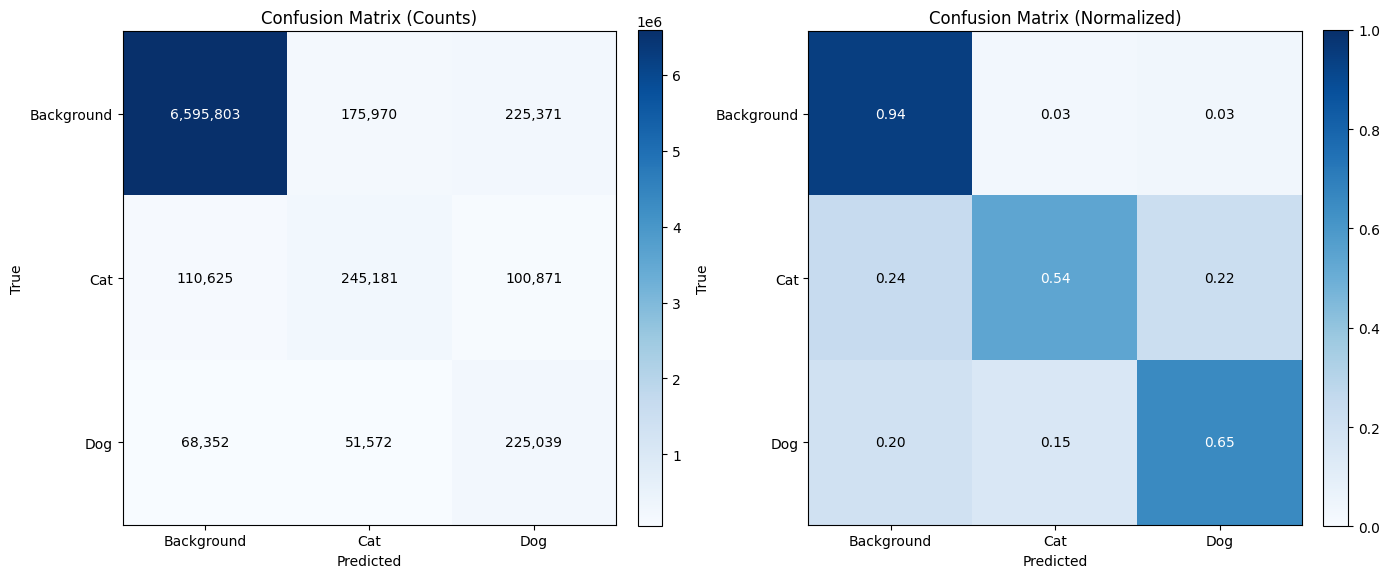

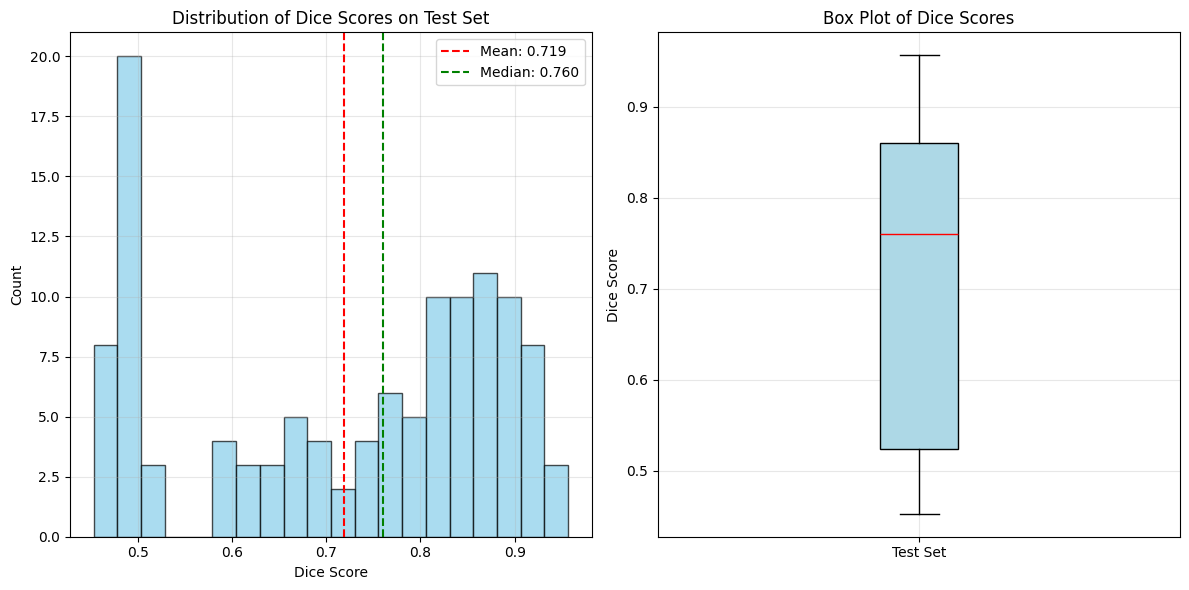

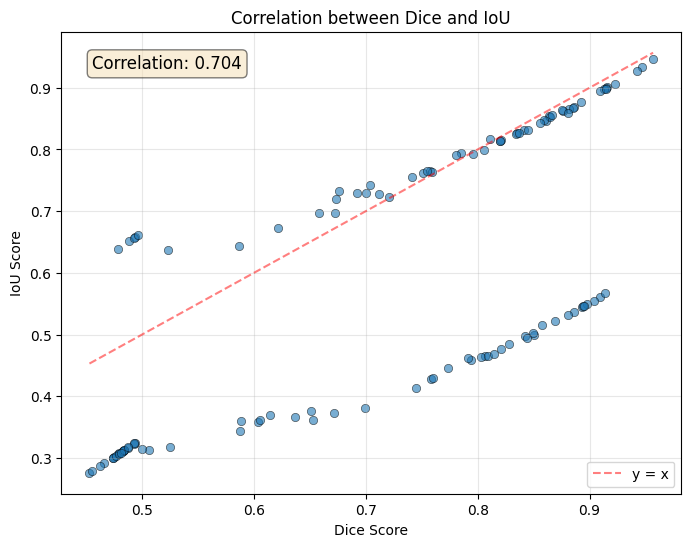


АНАЛИЗ ПРЕДСКАЗАНИЙ

ХУДШИЕ ПРЕДСКАЗАНИЯ (по Dice):
  - 000000406422_6565.jpg: Dice=0.453, IoU=0.276
  - 000000489944_1657.jpg: Dice=0.455, IoU=0.279
  - 000000485148_1904.jpg: Dice=0.462, IoU=0.287


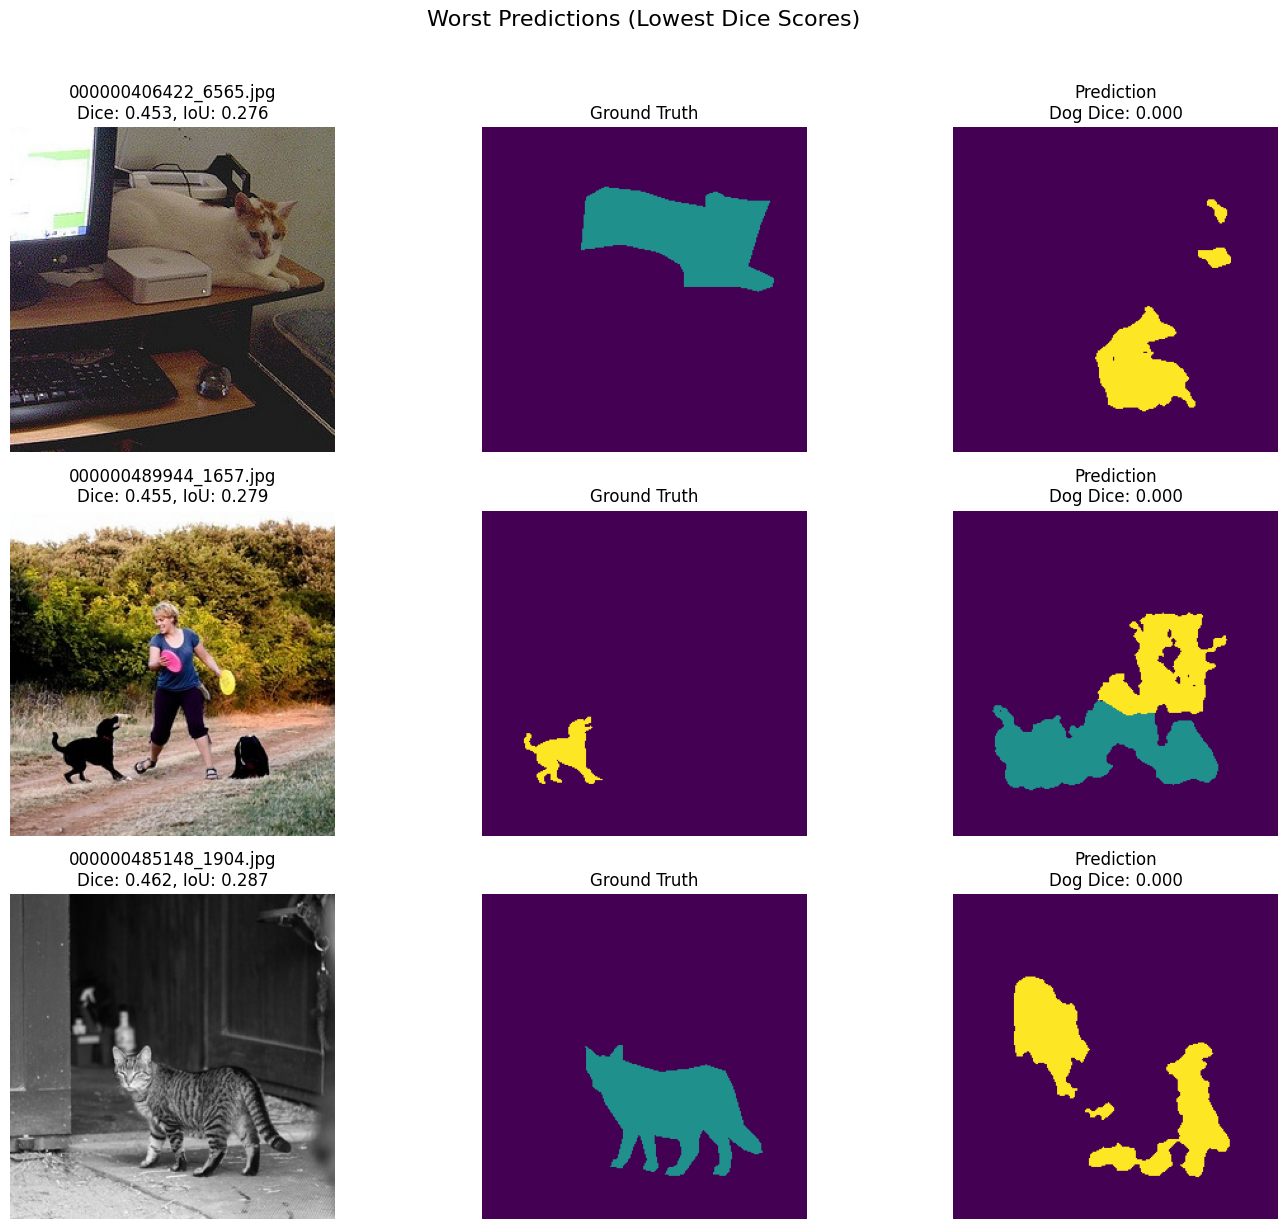


ЛУЧШИЕ ПРЕДСКАЗАНИЯ (по Dice):
  - 000000414495_3471.jpg: Dice=0.957, IoU=0.946
  - 000000408008_1937.jpg: Dice=0.947, IoU=0.934
  - 000000465591_1888.jpg: Dice=0.942, IoU=0.928


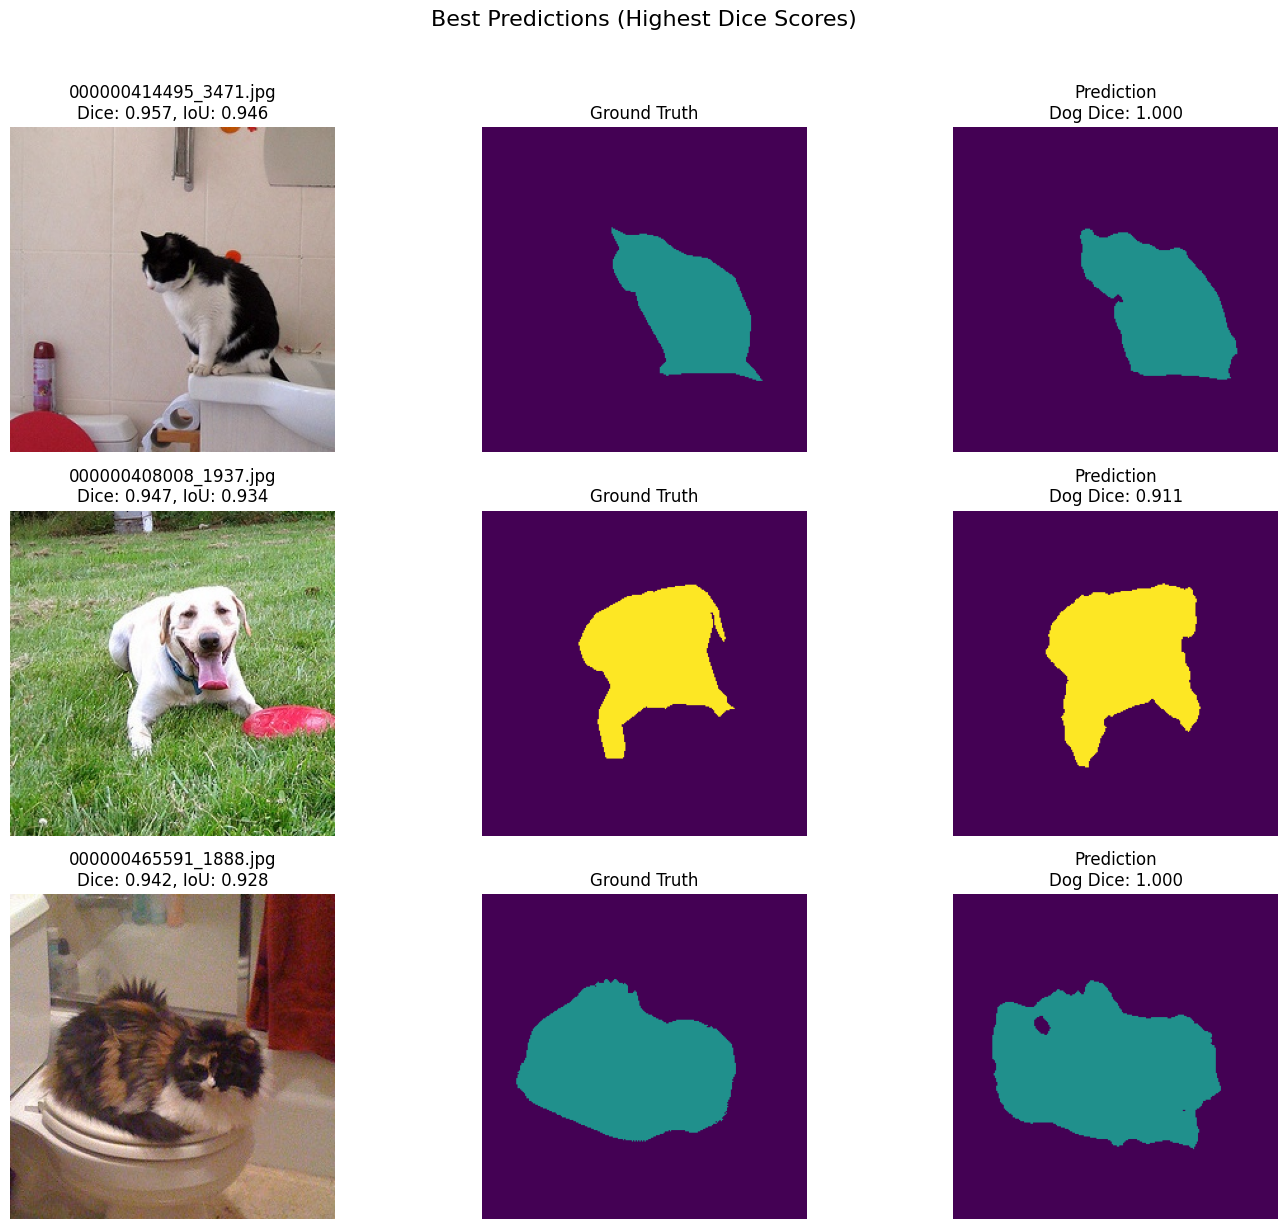


ДЕТАЛЬНЫЙ АНАЛИЗ ОШИБОК (средний пример):
Изображение: 000000563342_7436.jpg
Dice: 0.7603, IoU: 0.4289


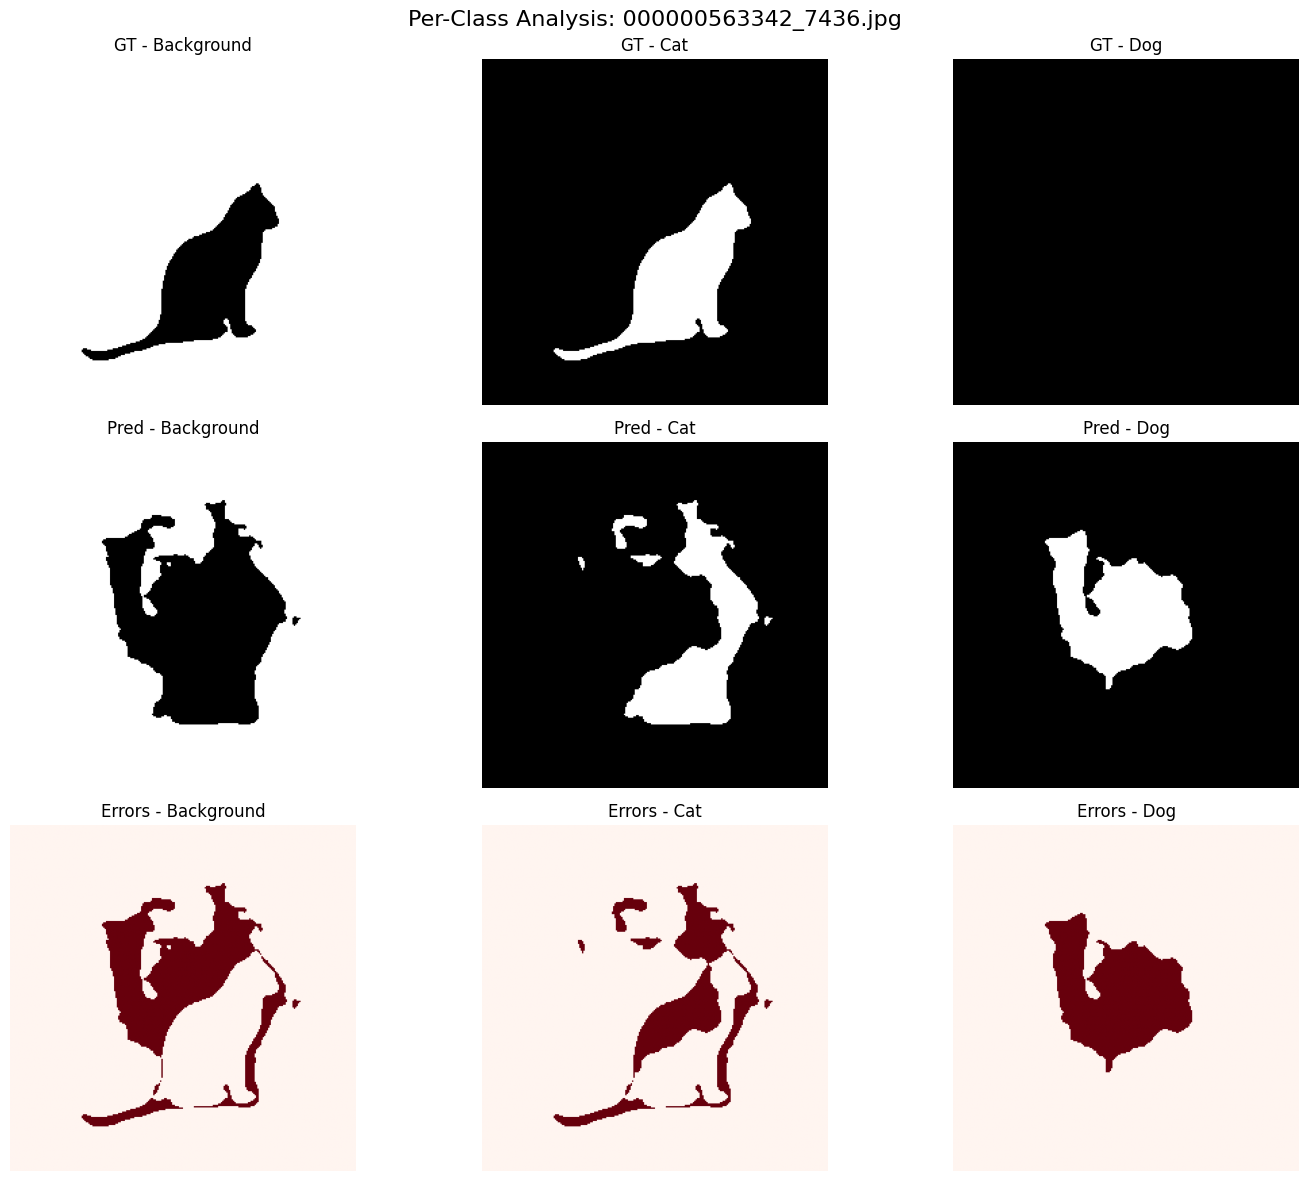


СОХРАНЕНИЕ РЕЗУЛЬТАТОВ

Результаты сохранены в папке: E:/Yandex_prakt/1_Proj_segment/enhanced_inference_results
  - inference_results.csv - детальные результаты по каждому изображению
  - summary_statistics.csv - сводная статистика
  - confusion_matrix.png - матрица ошибок
  - dice_distribution.png - распределение Dice scores
  - dice_iou_correlation.png - корреляция Dice и IoU
  - per_class_analysis.png - анализ по классам

Все результаты залогированы в ClearML!

Готово!


In [2]:
import os
import torch
import mmcv
import numpy as np
import matplotlib.pyplot as plt
from mmseg.apis import init_model, inference_model
from mmseg.utils import register_all_modules
from mmengine.config import Config
import pandas as pd
import cv2
from clearml import Task, Logger

# 1. Инициализация ClearML
task = Task.init(project_name='Segment', task_name='Enhanced_Inference_Analysis')
logger = Logger.current_logger()

register_all_modules()

# 2. Пути
config_path = 'E:/Yandex_prakt/mmsegmentation/configs/segformer/segformer_b0_custom.py'
checkpoint_path = 'E:/Yandex_prakt/mmsegmentation/work_dirs/segformer_b0_custom/iter_7000.pth'
test_img_dir = 'E:/Yandex_prakt/1_Proj_segment/stud_dataset/images/test'
test_ann_dir = 'E:/Yandex_prakt/1_Proj_segment/stud_dataset/annotations/test'
output_dir = 'E:/Yandex_prakt/1_Proj_segment/enhanced_inference_results'
os.makedirs(output_dir, exist_ok=True)

# 3. Инициализация модели
print("Инициализация модели...")
cfg = Config.fromfile(config_path)
model = init_model(cfg, checkpoint_path, device='cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Модель загружена на устройство: {next(model.parameters()).device}")

def post_process_mask_fixed(pred_mask, min_dog_area=100):
    """Удаление мелкого шума (ложных собак)"""
    dog_mask = (pred_mask == 2).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(dog_mask, connectivity=8)
    new_mask = pred_mask.copy()
    for label in range(1, num_labels):
        if stats[label, cv2.CC_STAT_AREA] < min_dog_area:
            new_mask[labels == label] = 0
    return new_mask

def calculate_dice(pred, target, num_classes=3):
    """Расчет Dice для каждого класса"""
    dice_scores = {}
    for i in range(num_classes):
        p = (pred == i).astype(np.float32)
        t = (target == i).astype(np.float32)
        
        if t.sum() == 0 and p.sum() == 0:
            dice = 1.0  # Если оба пустые - идеальное совпадение
        elif t.sum() == 0:
            dice = 0.0  # Если нет GT, но есть предсказание
        else:
            intersection = np.sum(p * t)
            dice = (2. * intersection) / (p.sum() + t.sum() + 1e-6)
        
        dice_scores[f'class_{i}'] = dice
    
    # Средний Dice по классам, присутствующим в GT
    valid_classes = [i for i in range(num_classes) if (target == i).sum() > 0]
    if valid_classes:
        mean_dice = np.mean([dice_scores[f'class_{i}'] for i in valid_classes])
    else:
        mean_dice = 0.0
    
    return mean_dice, dice_scores

def calculate_iou(pred, target, num_classes=3):
    """Расчет IoU для каждого класса"""
    iou_scores = {}
    for i in range(num_classes):
        p = (pred == i).astype(np.float32)
        t = (target == i).astype(np.float32)
        
        intersection = np.sum(p * t)
        union = np.sum(p + t) - intersection
        
        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = intersection / (union + 1e-6)
        
        iou_scores[f'class_{i}'] = iou
    
    # Средний IoU по классам
    mean_iou = np.mean(list(iou_scores.values()))
    return mean_iou, iou_scores

def calculate_confusion_matrix(pred, target, num_classes=3):
    """Расчет confusion matrix"""
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    
    for i in range(num_classes):
        for j in range(num_classes):
            cm[i, j] = np.sum((target == i) & (pred == j))
    
    return cm

# 4. Основной цикл инференса
results = []
all_preds = []
all_targets = []
class_names = ['Background', 'Cat', 'Dog']

image_files = [f for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
print(f"\nНайдено {len(image_files)} тестовых изображений")

print("\nЗапуск инференса...")
for idx, img_name in enumerate(image_files):
    img_path = os.path.join(test_img_dir, img_name)
    ann_path = os.path.join(test_ann_dir, os.path.splitext(img_name)[0] + '.png')
    
    if not os.path.exists(ann_path):
        print(f"Внимание: нет разметки для {img_name}")
        continue
    
    # Инференс с пост-обработкой
    result = inference_model(model, img_path)
    raw_mask = result.pred_sem_seg.data[0].cpu().numpy()
    pred_mask = post_process_mask_fixed(raw_mask)
    
    # Загрузка GT маски
    gt_mask = mmcv.imread(ann_path, flag='unchanged')
    if len(gt_mask.shape) == 3:
        gt_mask = gt_mask[:, :, 0]
    
    if pred_mask.shape != gt_mask.shape:
        gt_mask = cv2.resize(gt_mask, (pred_mask.shape[1], pred_mask.shape[0]), 
                            interpolation=cv2.INTER_NEAREST)
    
    # Расчет метрик
    dice_score, dice_by_class = calculate_dice(pred_mask, gt_mask)
    iou_score, iou_by_class = calculate_iou(pred_mask, gt_mask)
    
    # Сбор данных для матрицы ошибок
    all_preds.append(pred_mask.flatten())
    all_targets.append(gt_mask.flatten())
    
    # Информация о распределении пикселей
    height, width = gt_mask.shape
    total_pixels = height * width
    
    results.append({
        'name': img_name,
        'dice': dice_score,
        'iou': iou_score,
        'dice_by_class': dice_by_class,
        'iou_by_class': iou_by_class,
        'img': mmcv.imread(img_path),
        'pred': pred_mask,
        'gt': gt_mask,
        'pred_pixels': {class_names[i]: (pred_mask == i).sum() for i in range(3)},
        'gt_pixels': {class_names[i]: (gt_mask == i).sum() for i in range(3)},
        'total_pixels': total_pixels
    })
    
    if (idx + 1) % 10 == 0:
        print(f"Обработано: {idx + 1}/{len(image_files)}")
        # Логирование в ClearML
        logger.report_scalar(title="Progress", series="Processed", 
                           value=idx+1, iteration=idx+1)
        logger.report_scalar(title="Average Dice", series="Current", 
                           value=dice_score, iteration=idx+1)

# 5. Общая статистика с логированием в ClearML
print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ ИНФЕРЕНСА")
print("="*50)

# Средние метрики
all_dice = [r['dice'] for r in results]
all_iou = [r['iou'] for r in results]

mean_dice = np.mean(all_dice)
std_dice = np.std(all_dice)
mean_iou = np.mean(all_iou)
std_iou = np.std(all_iou)

print(f"\nСредний Dice на тесте: {mean_dice:.4f} ± {std_dice:.4f}")
print(f"Средний IoU на тесте:  {mean_iou:.4f} ± {std_iou:.4f}")

# Логирование основных метрик в ClearML
logger.report_single_value("Final_mDice_Test", mean_dice)
logger.report_single_value("Final_mIoU_Test", mean_iou)
logger.report_single_value("Dice_Std", std_dice)
logger.report_single_value("IoU_Std", std_iou)

# Dice по классам
dice_class_0 = np.mean([r['dice_by_class']['class_0'] for r in results])
dice_class_1 = np.mean([r['dice_by_class']['class_1'] for r in results])
dice_class_2 = np.mean([r['dice_by_class']['class_2'] for r in results])

print(f"\nDice по классам:")
print(f"  Class 0 (background): {dice_class_0:.4f}")
print(f"  Class 1 (cat):        {dice_class_1:.4f}")
print(f"  Class 2 (dog):        {dice_class_2:.4f}")

# IoU по классам
iou_class_0 = np.mean([r['iou_by_class']['class_0'] for r in results])
iou_class_1 = np.mean([r['iou_by_class']['class_1'] for r in results])
iou_class_2 = np.mean([r['iou_by_class']['class_2'] for r in results])

print(f"\nIoU по классам:")
print(f"  Class 0 (background): {iou_class_0:.4f}")
print(f"  Class 1 (cat):        {iou_class_1:.4f}")
print(f"  Class 2 (dog):        {iou_class_2:.4f}")

# Логирование метрик по классам
for i, name in enumerate(['Background', 'Cat', 'Dog']):
    logger.report_single_value(f"Dice_{name}", [dice_class_0, dice_class_1, dice_class_2][i])
    logger.report_single_value(f"IoU_{name}", [iou_class_0, iou_class_1, iou_class_2][i])

# Статистика по изображениям
results_df = pd.DataFrame(results)
dice_stats = {
    'Min': results_df['dice'].min(),
    'Max': results_df['dice'].max(),
    'Median': results_df['dice'].median(),
    '25%': results_df['dice'].quantile(0.25),
    '75%': results_df['dice'].quantile(0.75)
}

print(f"\nСтатистика Dice по изображениям:")
for stat, value in dice_stats.items():
    print(f"  {stat}:  {value:.4f}")

# 6. Матрица ошибок
print("\n" + "="*50)
print("МАТРИЦА ОШИБОК")
print("="*50)

all_preds_flat = np.concatenate(all_preds)
all_targets_flat = np.concatenate(all_targets)
cm = calculate_confusion_matrix(all_preds_flat, all_targets_flat)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Визуализация матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im1 = axes[0].imshow(cm, cmap='Blues')
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticks([0, 1, 2])
axes[0].set_yticks([0, 1, 2])
axes[0].set_xticklabels(class_names)
axes[0].set_yticklabels(class_names)

for i in range(3):
    for j in range(3):
        axes[0].text(j, i, f'{cm[i, j]:,}', ha="center", va="center", 
                     color="white" if cm[i, j] > cm.max()/2 else "black")

im2 = axes[1].imshow(cm_normalized, cmap='Blues', vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticks([0, 1, 2])
axes[1].set_yticks([0, 1, 2])
axes[1].set_xticklabels(class_names)
axes[1].set_yticklabels(class_names)

for i in range(3):
    for j in range(3):
        axes[1].text(j, i, f'{cm_normalized[i, j]:.2f}', ha="center", va="center", 
                     color="white" if cm_normalized[i, j] > 0.5 else "black")

plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()

# Сохранение и логирование в ClearML
conf_matrix_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(conf_matrix_path, dpi=150, bbox_inches='tight')
logger.report_matplotlib_figure(title="Confusion Matrix", series="Metrics", 
                               figure=plt, report_image=True)
plt.show()

# 7. Распределение Dice scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(all_dice, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(mean_dice, color='red', linestyle='--', 
           label=f'Mean: {mean_dice:.3f}')
plt.axvline(dice_stats['Median'], color='green', linestyle='--',
           label=f'Median: {dice_stats["Median"]:.3f}')
plt.xlabel('Dice Score')
plt.ylabel('Count')
plt.title('Distribution of Dice Scores on Test Set')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(all_dice, vert=True, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='red'))
plt.ylabel('Dice Score')
plt.title('Box Plot of Dice Scores')
plt.grid(True, alpha=0.3)
plt.xticks([1], ['Test Set'])

plt.tight_layout()
dice_dist_path = os.path.join(output_dir, 'dice_distribution.png')
plt.savefig(dice_dist_path, dpi=150, bbox_inches='tight')
logger.report_matplotlib_figure(title="Dice Distribution", series="Metrics", 
                               figure=plt, report_image=True)
plt.show()

# 8. Корреляция Dice и IoU
plt.figure(figsize=(8, 6))
plt.scatter(all_dice, all_iou, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.xlabel('Dice Score')
plt.ylabel('IoU Score')
plt.title('Correlation between Dice and IoU')
plt.grid(True, alpha=0.3)

x_line = np.linspace(min(all_dice), max(all_dice), 100)
plt.plot(x_line, x_line, 'r--', alpha=0.5, label='y = x')

correlation = np.corrcoef(all_dice, all_iou)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.legend()
corr_path = os.path.join(output_dir, 'dice_iou_correlation.png')
plt.savefig(corr_path, dpi=150, bbox_inches='tight')
logger.report_matplotlib_figure(title="Dice-IoU Correlation", series="Metrics", 
                               figure=plt, report_image=True)
plt.show()

# 9. Примеры лучших и худших предсказаний
print("\n" + "="*50)
print("АНАЛИЗ ПРЕДСКАЗАНИЙ")
print("="*50)

results_sorted = sorted(results, key=lambda x: x['dice'])
worst_3 = results_sorted[:3]
best_3 = results_sorted[-3:][::-1]

# Функция для отрисовки предсказаний с ClearML логированием
def plot_predictions_with_clearml(data_list, title_prefix):
    fig, axes = plt.subplots(len(data_list), 3, figsize=(15, 4*len(data_list)))
    if len(data_list) == 1:
        axes = [axes]
    
    for idx, (ax_row, data) in enumerate(zip(axes, data_list)):
        # Оригинальное изображение
        ax_row[0].imshow(mmcv.bgr2rgb(data['img']))
        ax_row[0].set_title(f"{data['name']}\nDice: {data['dice']:.3f}, IoU: {data['iou']:.3f}")
        ax_row[0].axis('off')
        
        # Ground Truth
        ax_row[1].imshow(data['gt'], cmap='viridis', vmin=0, vmax=2)
        ax_row[1].set_title(f"Ground Truth")
        ax_row[1].axis('off')
        
        # Prediction
        ax_row[2].imshow(data['pred'], cmap='viridis', vmin=0, vmax=2)
        dog_dice = data['dice_by_class']['class_2']
        ax_row[2].set_title(f"Prediction\nDog Dice: {dog_dice:.3f}")
        ax_row[2].axis('off')
    
    plt.suptitle(title_prefix, fontsize=16, y=1.02)
    plt.tight_layout()
    
    # Логирование в ClearML
    logger.report_matplotlib_figure(title=title_prefix, series="Visualizations", 
                                   figure=plt, report_image=True)
    plt.show()

# Визуализация лучших и худших
print("\nХУДШИЕ ПРЕДСКАЗАНИЯ (по Dice):")
for ex in worst_3:
    print(f"  - {ex['name']}: Dice={ex['dice']:.3f}, IoU={ex['iou']:.3f}")
plot_predictions_with_clearml(worst_3, "Worst Predictions (Lowest Dice Scores)")

print("\nЛУЧШИЕ ПРЕДСКАЗАНИЯ (по Dice):")
for ex in best_3:
    print(f"  - {ex['name']}: Dice={ex['dice']:.3f}, IoU={ex['iou']:.3f}")
plot_predictions_with_clearml(best_3, "Best Predictions (Highest Dice Scores)")

# 10. Детальный анализ ошибок для одного примера
middle_idx = len(results_sorted) // 2
sample = results_sorted[middle_idx]

print(f"\nДЕТАЛЬНЫЙ АНАЛИЗ ОШИБОК (средний пример):")
print(f"Изображение: {sample['name']}")
print(f"Dice: {sample['dice']:.4f}, IoU: {sample['iou']:.4f}")

# Визуализация по классам
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for class_idx in range(3):
    class_name = class_names[class_idx]
    
    gt_class = (sample['gt'] == class_idx).astype(np.uint8)
    axes[0, class_idx].imshow(gt_class, cmap='gray')
    axes[0, class_idx].set_title(f"GT - {class_name}")
    axes[0, class_idx].axis('off')
    
    pred_class = (sample['pred'] == class_idx).astype(np.uint8)
    axes[1, class_idx].imshow(pred_class, cmap='gray')
    axes[1, class_idx].set_title(f"Pred - {class_name}")
    axes[1, class_idx].axis('off')
    
    errors = ((sample['pred'] == class_idx) != (sample['gt'] == class_idx)).astype(np.uint8)
    axes[2, class_idx].imshow(errors, cmap='Reds')
    axes[2, class_idx].set_title(f"Errors - {class_name}")
    axes[2, class_idx].axis('off')

plt.suptitle(f"Per-Class Analysis: {sample['name']}", fontsize=16)
plt.tight_layout()
per_class_path = os.path.join(output_dir, 'per_class_analysis.png')
plt.savefig(per_class_path, dpi=150, bbox_inches='tight')
logger.report_matplotlib_figure(title="Per-Class Analysis", series="Analysis", 
                               figure=plt, report_image=True)
plt.show()

# 11. Сохранение результатов в CSV
print("\n" + "="*50)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*50)

# Подготовка данных для CSV
csv_data = []
for r in results:
    row = {
        'image_name': r['name'],
        'dice': r['dice'],
        'iou': r['iou'],
        'dice_background': r['dice_by_class']['class_0'],
        'dice_cat': r['dice_by_class']['class_1'],
        'dice_dog': r['dice_by_class']['class_2'],
        'iou_background': r['iou_by_class']['class_0'],
        'iou_cat': r['iou_by_class']['class_1'],
        'iou_dog': r['iou_by_class']['class_2'],
        'gt_background_pixels': r['gt_pixels']['Background'],
        'gt_cat_pixels': r['gt_pixels']['Cat'],
        'gt_dog_pixels': r['gt_pixels']['Dog'],
        'pred_background_pixels': r['pred_pixels']['Background'],
        'pred_cat_pixels': r['pred_pixels']['Cat'],
        'pred_dog_pixels': r['pred_pixels']['Dog'],
        'total_pixels': r['total_pixels']
    }
    csv_data.append(row)

df_results = pd.DataFrame(csv_data)
results_csv_path = os.path.join(output_dir, 'inference_results.csv')
df_results.to_csv(results_csv_path, index=False)

# Сводная статистика
summary_stats = {
    'metric': ['mDice', 'mIoU', 'Dice Background', 'Dice Cat', 'Dice Dog',
               'IoU Background', 'IoU Cat', 'IoU Dog'],
    'mean': [mean_dice, mean_iou, dice_class_0, dice_class_1, dice_class_2,
             iou_class_0, iou_class_1, iou_class_2],
    'std': [std_dice, std_iou,
            np.std([r['dice_by_class']['class_0'] for r in results]),
            np.std([r['dice_by_class']['class_1'] for r in results]),
            np.std([r['dice_by_class']['class_2'] for r in results]),
            np.std([r['iou_by_class']['class_0'] for r in results]),
            np.std([r['iou_by_class']['class_1'] for r in results]),
            np.std([r['iou_by_class']['class_2'] for r in results])],
    'min': [min(all_dice), min(all_iou),
            min([r['dice_by_class']['class_0'] for r in results]),
            min([r['dice_by_class']['class_1'] for r in results]),
            min([r['dice_by_class']['class_2'] for r in results]),
            min([r['iou_by_class']['class_0'] for r in results]),
            min([r['iou_by_class']['class_1'] for r in results]),
            min([r['iou_by_class']['class_2'] for r in results])],
    'max': [max(all_dice), max(all_iou),
            max([r['dice_by_class']['class_0'] for r in results]),
            max([r['dice_by_class']['class_1'] for r in results]),
            max([r['dice_by_class']['class_2'] for r in results]),
            max([r['iou_by_class']['class_0'] for r in results]),
            max([r['iou_by_class']['class_1'] for r in results]),
            max([r['iou_by_class']['class_2'] for r in results])]
}

df_summary = pd.DataFrame(summary_stats)
summary_csv_path = os.path.join(output_dir, 'summary_statistics.csv')
df_summary.to_csv(summary_csv_path, index=False)

print(f"\nРезультаты сохранены в папке: {output_dir}")
print(f"  - inference_results.csv - детальные результаты по каждому изображению")
print(f"  - summary_statistics.csv - сводная статистика")
print(f"  - confusion_matrix.png - матрица ошибок")
print(f"  - dice_distribution.png - распределение Dice scores")
print(f"  - dice_iou_correlation.png - корреляция Dice и IoU")
print(f"  - per_class_analysis.png - анализ по классам")

# 12. Логирование файлов в ClearML
task.upload_artifact('inference_results.csv', results_csv_path)
task.upload_artifact('summary_statistics.csv', summary_csv_path)
task.upload_artifact('confusion_matrix.png', conf_matrix_path)
task.upload_artifact('dice_distribution.png', dice_dist_path)
task.upload_artifact('dice_iou_correlation.png', corr_path)
task.upload_artifact('per_class_analysis.png', per_class_path)

print("\nВсе результаты залогированы в ClearML!")
print("\nГотово!")

task.close()